# Setup

In [1]:
import datetime
import flopy as fp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pickle
from pypalettes import load_cmap
import re
import seaborn as sns
import shapely.geometry
import shapely.ops

import sys
sys.path.append('D://repos//custom_packages')
import dataviz as dv

In [2]:
def draw_fields(matrix, fields, plot):
    """
    Main code got from:
    https://stackoverflow.com/a/76356970
    """
    xbound = [i for i in range(1, matrix.shape[1]+1)]
    ybound = [i for i in range(1, matrix.shape[0]+1)]

    mask = np.zeros(shape=(matrix.shape[0], matrix.shape[1]))
    mask = mask > 1
    # Add fields in the mask
    for field in fields.keys():
        for rc in fields[field]:
            mask[rc[0], rc[1]] = True
    # Create the geometries
    geoms = []
    for yidx, xidx in zip(*np.where(mask)):
        geoms.append(shapely.geometry.box(xbound[xidx], ybound[yidx], xbound[xidx+1], ybound[yidx+1]))
    full_geom = shapely.ops.unary_union(geoms)

    if plot:
        plt.imshow(matrix)
        for geom in full_geom.geoms:
            plt.plot(*geom.exterior.xy, linewidth=1, color='w')
    else:
        return full_geom

def get_hds2d(hds1d, nodes_ref, layer, ts, sp):
    """
    Obtain a 2d hds numpy array with the same dimensions as the MODFLOW grid,
    starting from a flopy.utils.binaryfile.HeadUFile.
    Need to provide a correspondence between nodes, row and column (nodes_ref)
    Works on a single layer, timestep and stress period

    hds1d: flopy.utils.binaryfile.HeadUFile
    nodes_ref: pandas.DataFrame
        columns needed:
            - node
            - row
            - column
    layer: int
        Layer to extract
    ts: int
        Time step to extract
    sp: int
        Stress period to extract
    """
    hds1d = hds1d.get_data(kstpkper = (ts-1, sp-1))[layer-1]
    hds2d = np.zeros(shape = (nodes_ref.row.max(), nodes_ref.column.max()))
    for r in range(hds2d.shape[0]):
        for c in range(hds2d.shape[1]):
            hds2d[r,c] = hds1d[nodes_ref.loc[(nodes_ref.row == r+1) & (nodes_ref.column == c+1)].node.values[0]-1]
    return hds2d

# Path definition

In [3]:
model_cwd = 'D:/MAURICE/MAURICE Model/MAU_v2/MAU_v2_transient/MAU_v2_5_1'
model_name = 'M2v5_1'
date_start = datetime.datetime(2023,9,3)
if not os.path.exists(os.path.join(model_cwd, 'plot')):
    os.makedirs(os.path.join(model_cwd, 'plot'))

# Visualization

## Subplots

In [34]:
# Read
target_results = pd.read_csv(os.path.join(model_cwd, f'{model_name}_headtarget_resids.csv'))

# Obtain field "date"
dates = [date_start + datetime.timedelta(0, t) for t in target_results.Time]
target_results['Date'] = dates

# Sort from North to South
df_plot = target_results.sort_values('Y', ascending=False).copy()

print('Number of head target points: ', len(target_results.Name.unique()))

Number of head target points:  48


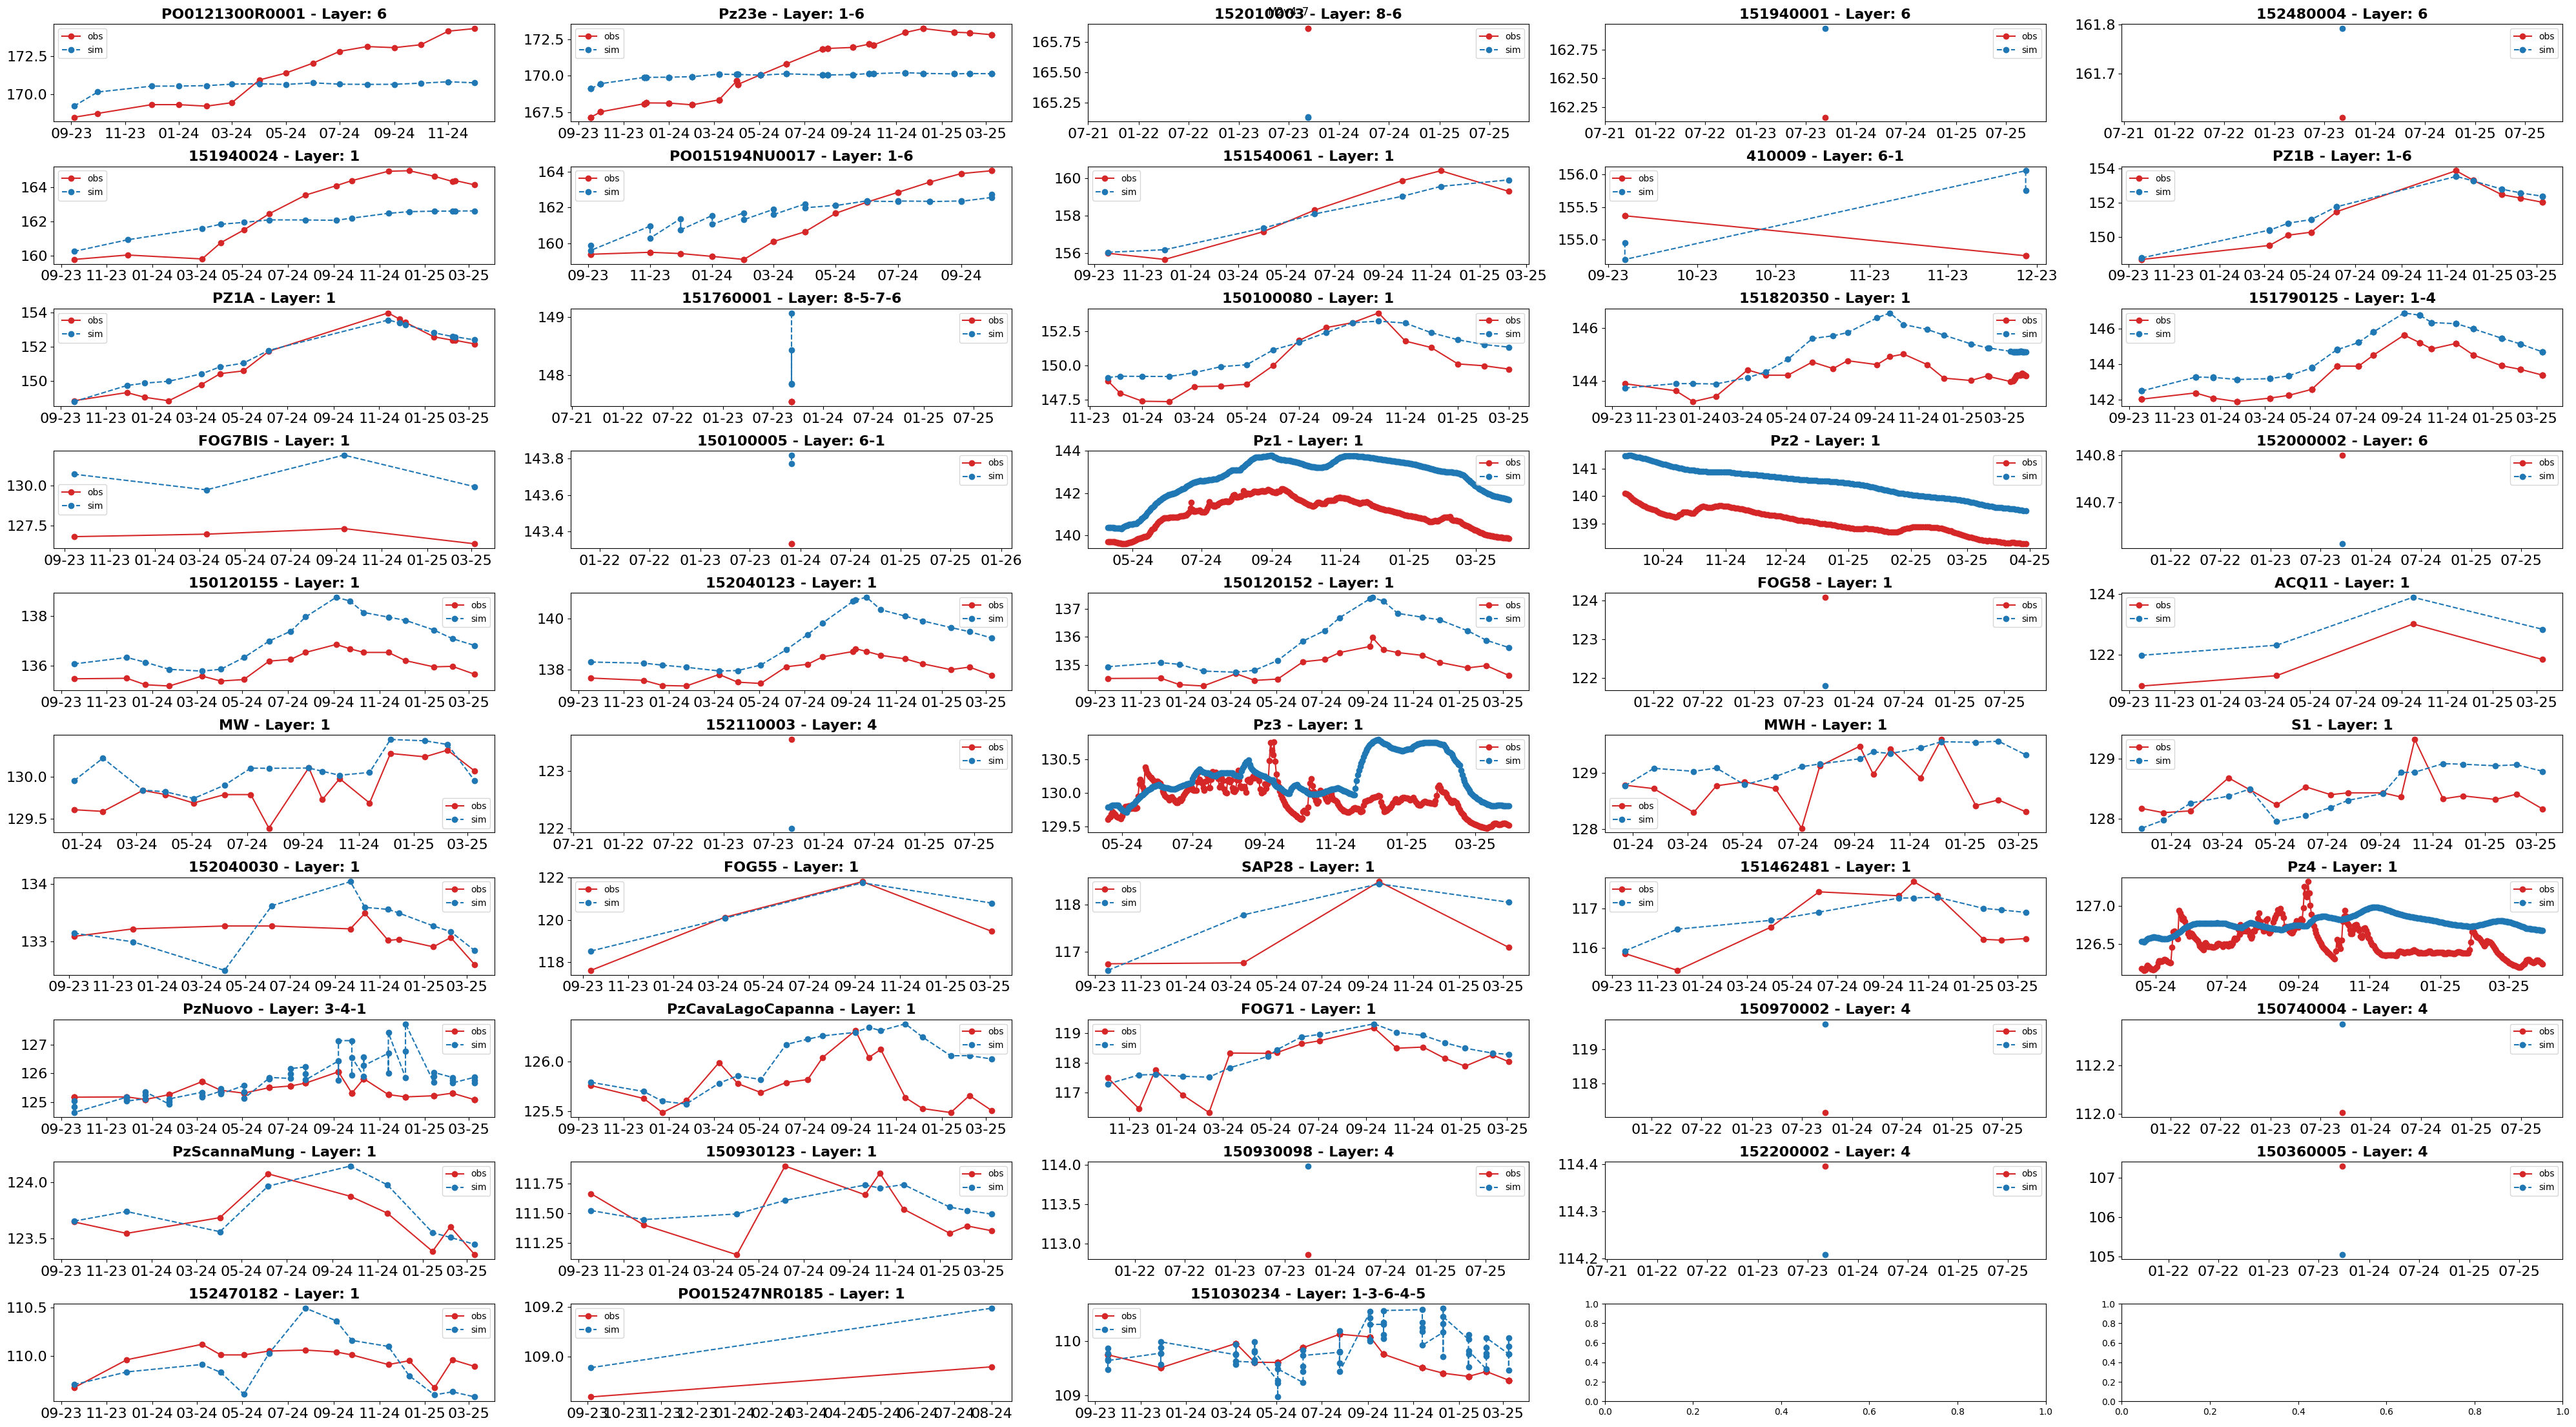

In [35]:
# Visualize subplots
fmt = mdates.DateFormatter('%m-%y')

fig, axes = plt.subplots(10, 5, figsize = dv.cm2inch(33.87*3, 19.05*3))

i = 0
for ax in axes.flatten():
    if i < len(df_plot.Name.unique()):
        tool = df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], :].sort_values('Time').copy()
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Observed'],
                marker = 'o', linestyle = '-', color = 'tab:red', label = 'obs')
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Simulated'],
                marker = 'o', linestyle = '--', color = 'tab:blue', label = 'sim')
        ax.legend()

        title = df_plot.Name.unique()[i] + ' - Layer: '+ '-'.join([f'{x}' for x in df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], 'Layer'].unique()])

        ax.set_title(title, fontweight = 'bold', ha = 'center', fontsize = 16)
        ax.xaxis.set_major_formatter(fmt)
        ax.tick_params(axis='both', which='major', labelsize=16)
        
    i += 1

fig.suptitle(model_name)
fig.tight_layout()

fig.savefig(os.path.join(model_cwd, 'plot', 'target-subplots.png'), bbox_inches = 'tight', dpi = 300)

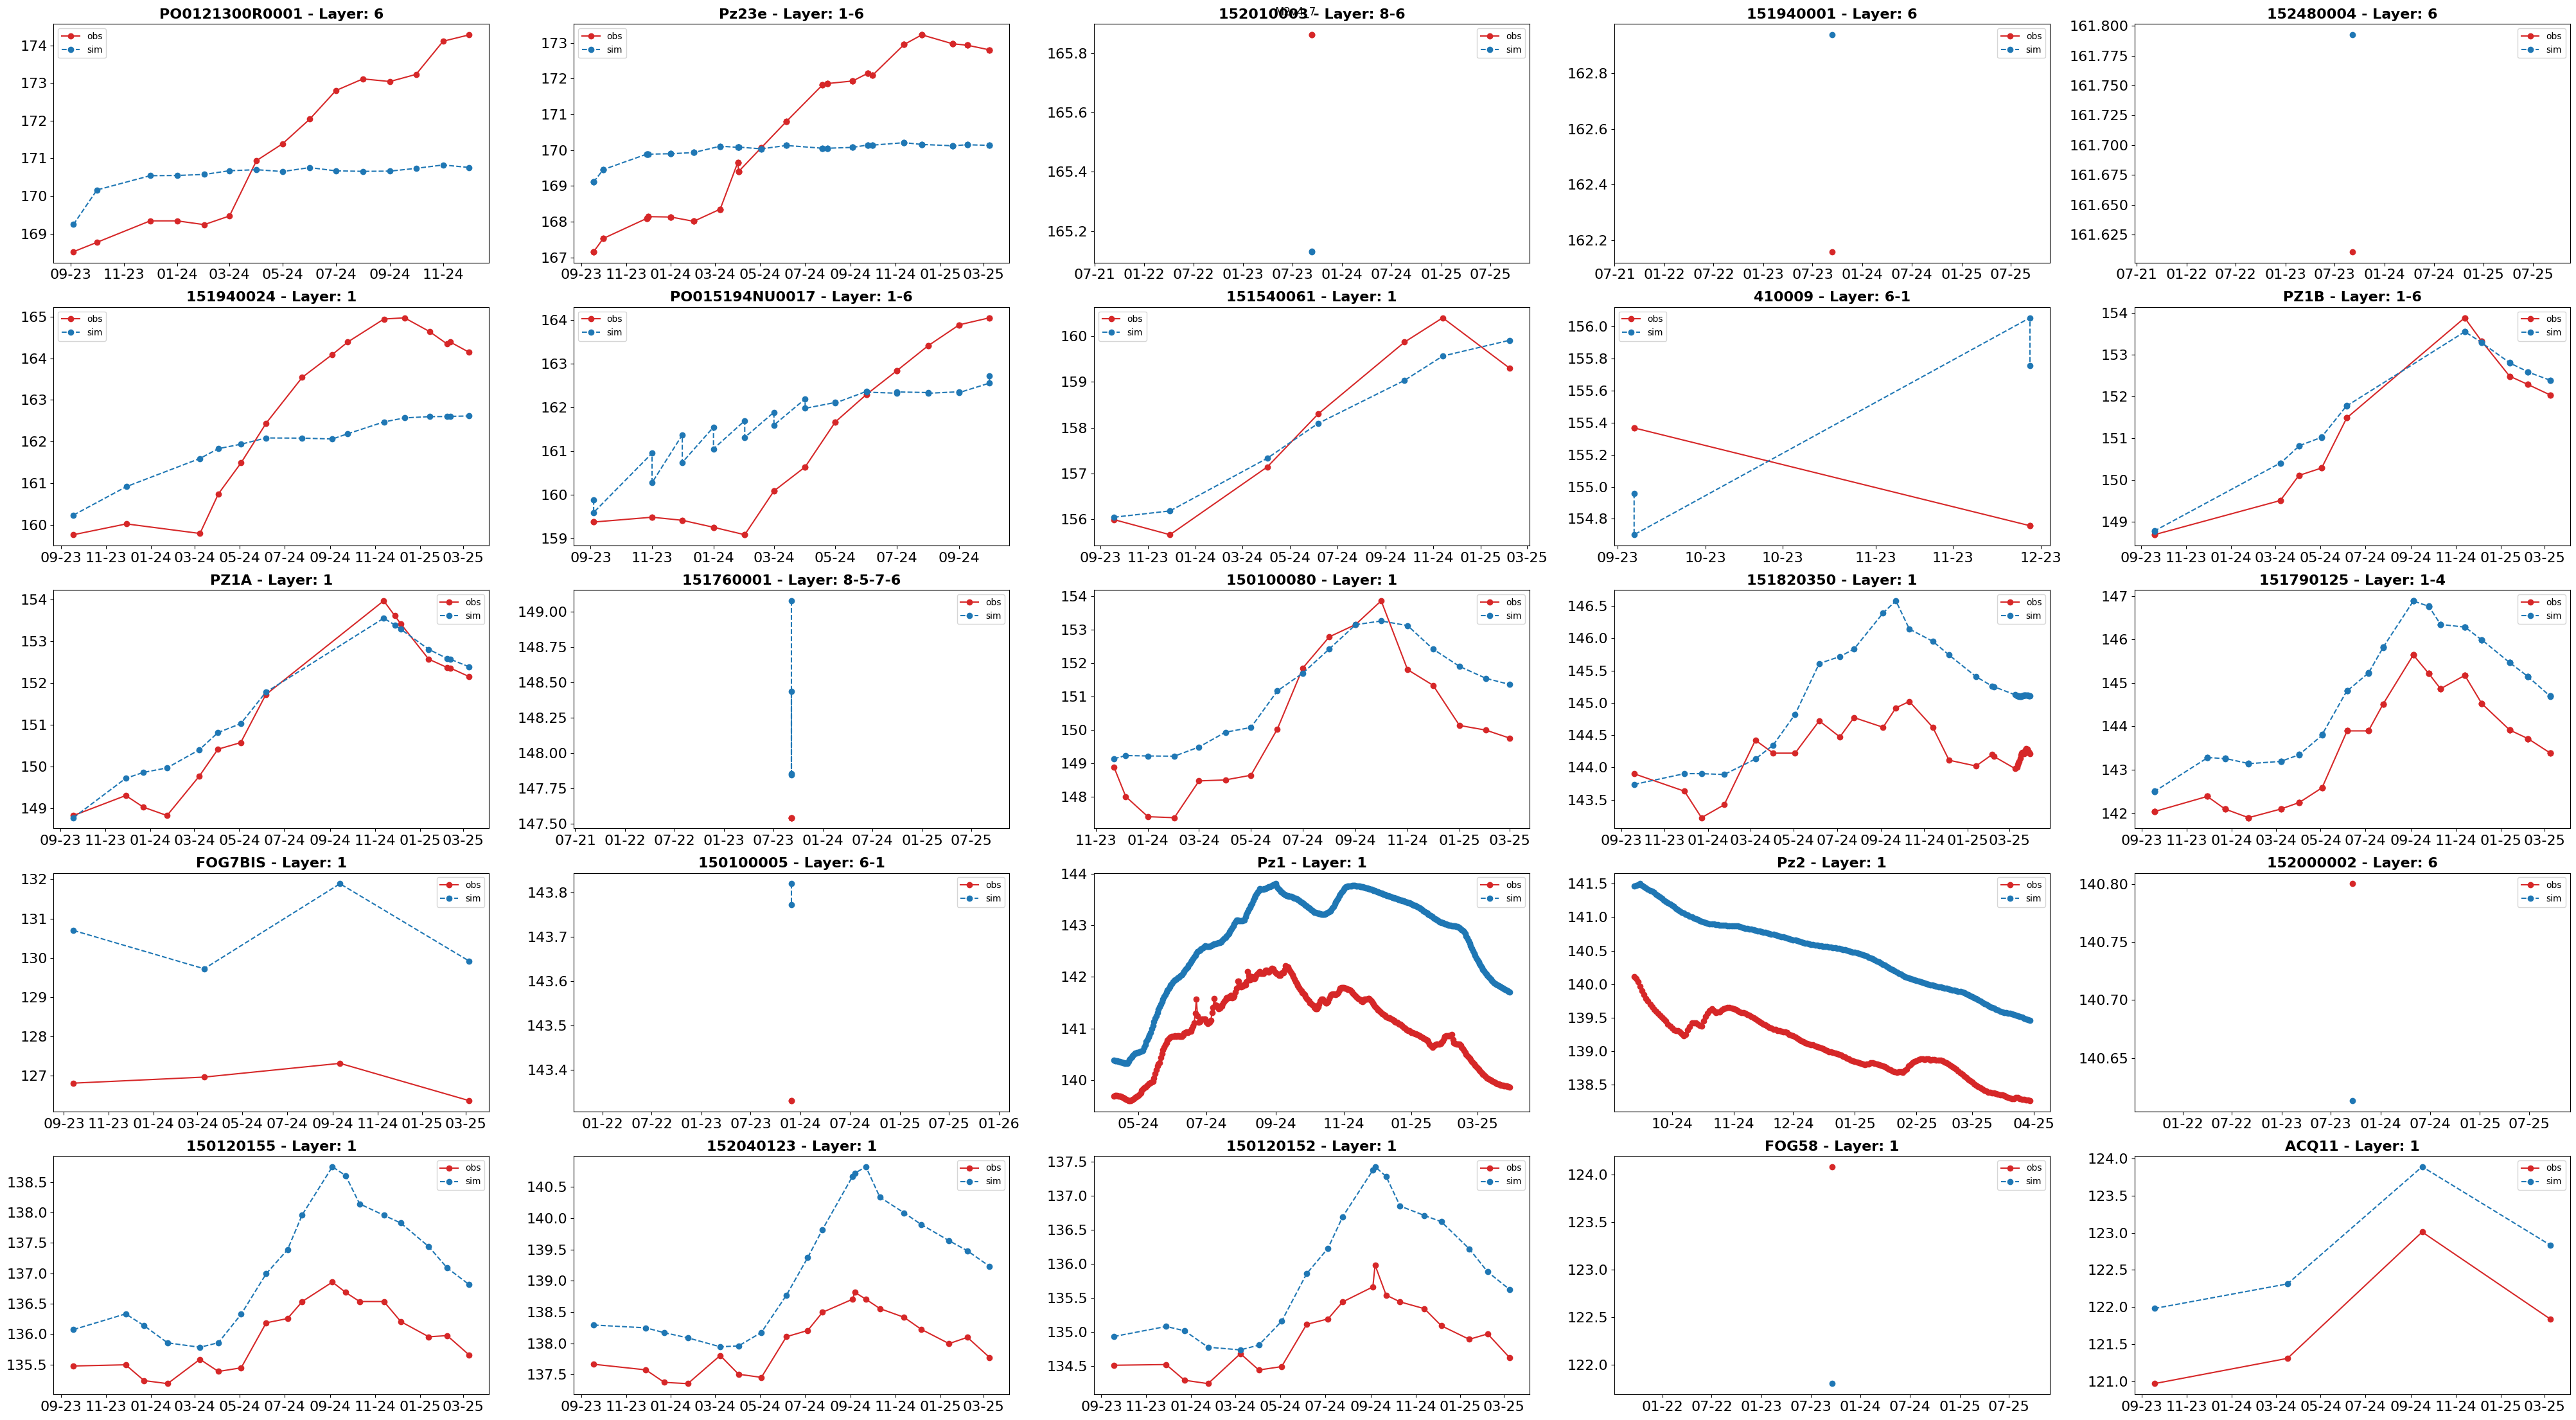

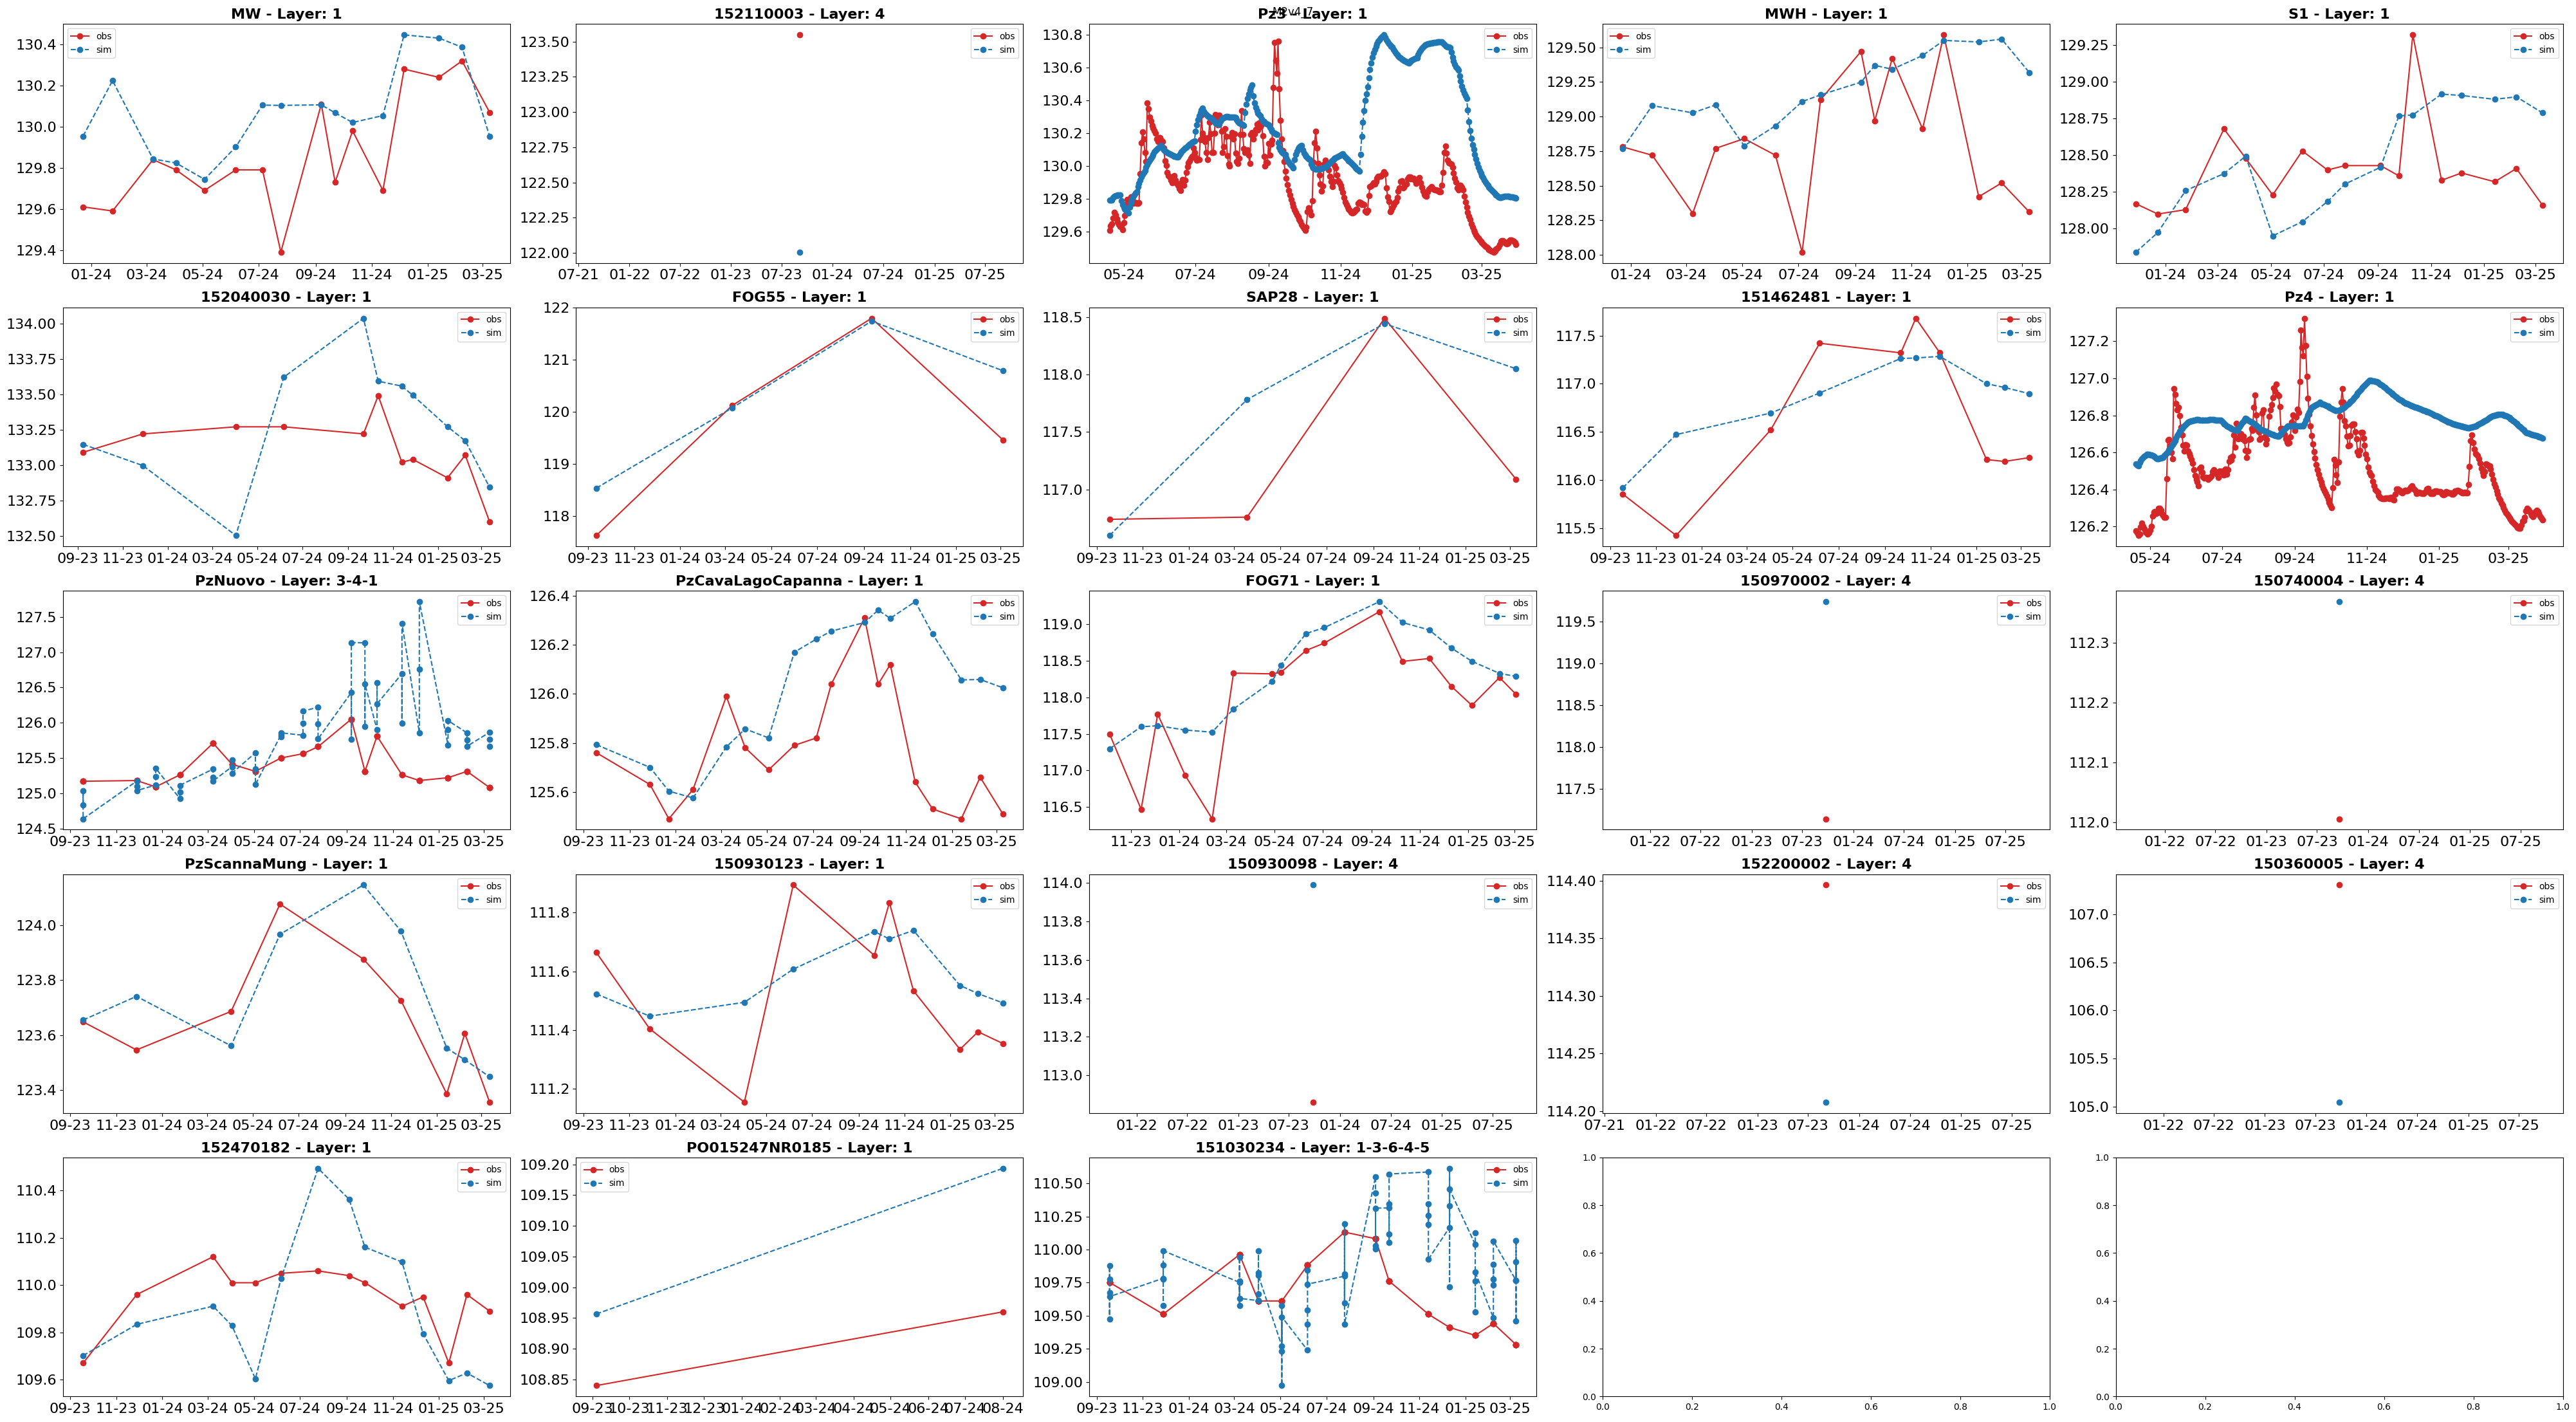

In [36]:
# Visualize subplots, split in 2
fmt = mdates.DateFormatter('%m-%y')

fig, axes = plt.subplots(5, 5, figsize = dv.cm2inch(33.87*3, 19.05*3))

i = 0
for ax in axes.flatten():
    if i < len(df_plot.Name.unique()):
        tool = df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], :].sort_values('Time').copy()
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Observed'],
                marker = 'o', linestyle = '-', color = 'tab:red', label = 'obs')
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Simulated'],
                marker = 'o', linestyle = '--', color = 'tab:blue', label = 'sim')
        ax.legend()

        title = df_plot.Name.unique()[i] + ' - Layer: '+ '-'.join([f'{x}' for x in df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], 'Layer'].unique()])

        ax.set_title(title, fontweight = 'bold', ha = 'center', fontsize = 16)
        ax.xaxis.set_major_formatter(fmt)
        ax.tick_params(axis='both', which='major', labelsize=16)
        i += 1

fig.suptitle(model_name)
fig.tight_layout()
fig.savefig(os.path.join(model_cwd, 'plot', 'target-subplots-part1.png'), bbox_inches = 'tight', dpi = 300)

fig, axes = plt.subplots(5, 5, figsize = dv.cm2inch(33.87*3, 19.05*3))

for ax in axes.flatten():
    if i < len(df_plot.Name.unique()):
        tool = df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], :].sort_values('Time').copy()
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Observed'],
                marker = 'o', linestyle = '-', color = 'tab:red', label = 'obs')
        ax.plot(tool.loc[:, 'Date'],
                tool.loc[:, 'Simulated'],
                marker = 'o', linestyle = '--', color = 'tab:blue', label = 'sim')
        ax.legend()

        title = df_plot.Name.unique()[i] + ' - Layer: '+ '-'.join([f'{x}' for x in df_plot.loc[df_plot.Name == df_plot.Name.unique()[i], 'Layer'].unique()])

        ax.set_title(title, fontweight = 'bold', ha = 'center', fontsize = 16)
        ax.xaxis.set_major_formatter(fmt)
        ax.tick_params(axis='both', which='major', labelsize=16)  
        i += 1

fig.suptitle(model_name)
fig.tight_layout()
fig.savefig(os.path.join(model_cwd, 'plot', 'target-subplots-part2.png'), bbox_inches = 'tight', dpi = 300)

## Scatterplot obs vs sim

In [37]:
# Read
target_results = pd.read_csv(os.path.join(model_cwd, f'{model_name}_headtarget_resids.csv'))

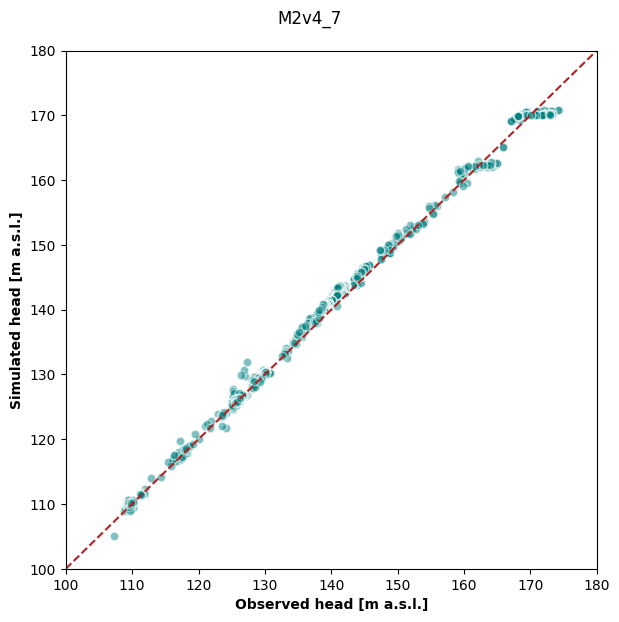

In [38]:
fig, ax = plt.subplots(1,1, figsize = dv.cm2inch(8*2, 8*2))

sns.scatterplot(df_plot, x = 'Observed', y = 'Simulated', marker = '.', ax = ax, alpha = 0.5,
                s = 150, color = 'teal')

ax.axline((0,0), (180,180), color='firebrick', linestyle='--')
ax.set_xlim(100,180)
ax.set_ylim(100,180)

ax.set_xlabel('Observed head [m a.s.l.]', fontweight = 'bold')
ax.set_ylabel('Simulated head [m a.s.l.]', fontweight = 'bold')

fig.suptitle(model_name)
fig.tight_layout()
fig.savefig(os.path.join(model_cwd, 'plot', 'obs-vs-sim.png'), bbox_inches = 'tight', dpi = 300)

## Selected points

In [39]:
# Read
target_results = pd.read_csv(os.path.join(model_cwd, f'{model_name}_headtarget_resids.csv'))

# Obtain field "date"
dates = [date_start + datetime.timedelta(0, t) for t in target_results.Time]
target_results['Date'] = dates

<Axes: xlabel='Date'>

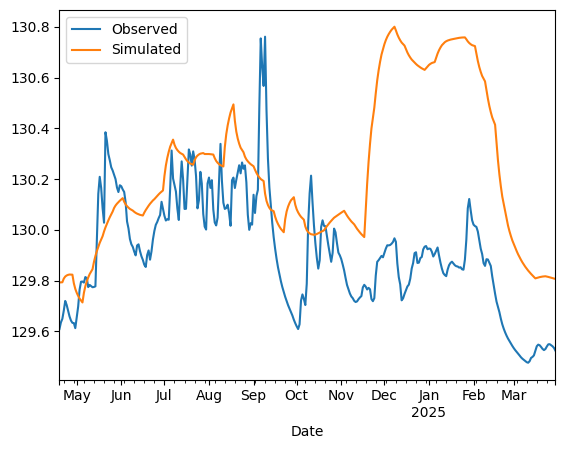

In [40]:
target_results.loc[target_results.Name == 'Pz3', ['Observed', 'Simulated', 'Date']].set_index('Date').plot()

## Weekly dataloggers

In [41]:
# Read
target_results = pd.read_csv(os.path.join(model_cwd, f'{model_name}_headtarget_resids.csv'))

# Obtain field "date"
dates = [date_start + datetime.timedelta(0, t) for t in target_results.Time]
target_results['Date'] = dates

In [42]:
weeks = pd.date_range('2023-09-03', '2025-03-30', freq='W-SUN')
weeks = pd.DataFrame({
    'sp': [f'SP{i}' for i in range(1, len(weeks)+1)],
    'weeks': weeks
})
weeks.drop(weeks.index[-1], inplace=True)

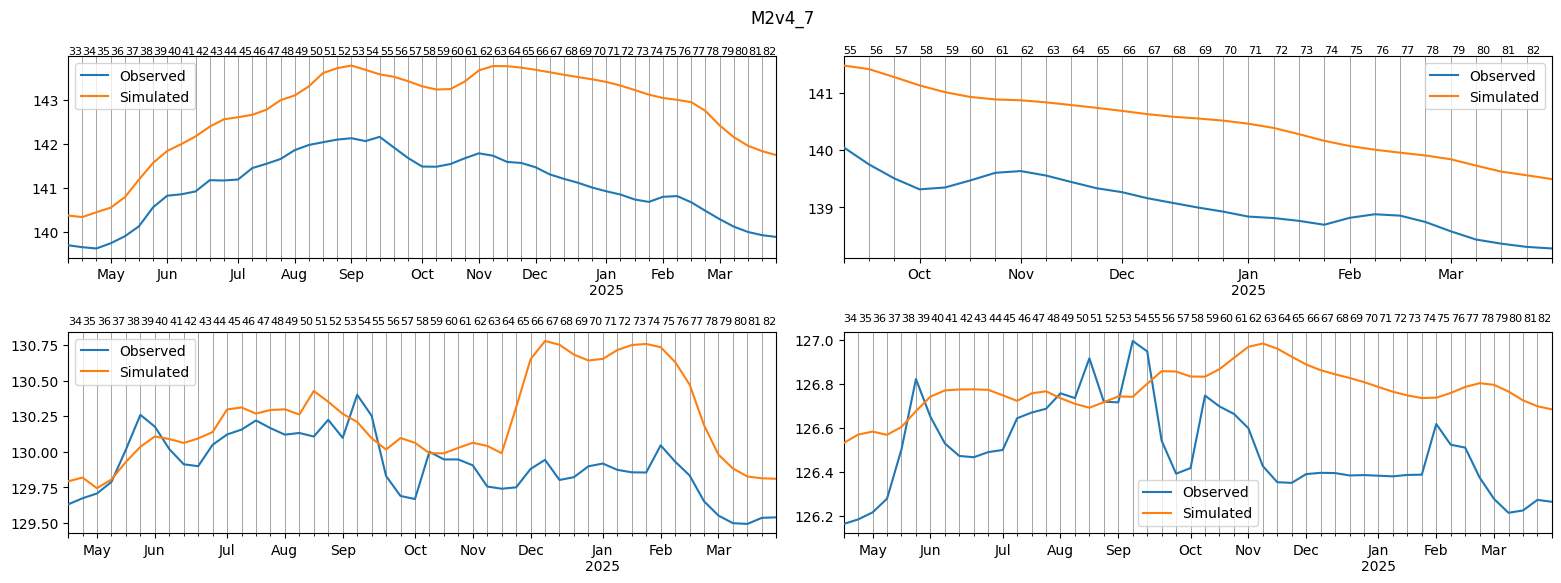

In [43]:
points = ['Pz1', 'Pz2', 'Pz3', 'Pz4']

fig, axes = plt.subplots(2,2, figsize = dv.cm2inch(40, 15))

for p, ax in zip(points, axes.flatten()):
    target_results.loc[target_results.Name == p, ['Observed', 'Simulated', 'Date']].set_index('Date').resample('1W').mean().plot(ax = ax, zorder = 10)
    for _, row in weeks.iterrows():
        if row.weeks > target_results.loc[target_results.Name == p, ['Date']].min().Date:
            ax.axvline(row.weeks, zorder= 1, linewidth = 0.5, color = 'gray')
            ax.text(row.weeks, ax.get_ylim()[1]+0.05, re.sub("[^0-9]", "", row.sp), fontsize = 8)
    ax.set_xlabel('')

fig.suptitle(model_name)
fig.tight_layout()
fig.savefig(os.path.join(model_cwd, 'plot', 'weekly-resampled.png'), bbox_inches = 'tight', dpi = 300)

## Difference in heads with another model

In [302]:
# Setup parameters
# Reference SP
sp_ref = 82 # 78: end of irr, 82: end of simulation, before irrigation season
ts_ref = 5  # reference time step
# Reference layer
layer = 1
# Model 1
model_cwd_1 = model_cwd
model_name_1 = model_name
# Model 2
model_cwd_2 = 'D:/MAURICE/MAURICE Model/MAU_v2/MAU_v2_transient/MAU_v2_5_0'
model_name_2 = 'M2v5_0'

# If ModflowUSG
nodes_ref = pd.read_csv('D:/MAURICE/MAURICE Model/MAU_v2/props_for_postprocessing/nodes_row_column.csv')

In [ ]:
# cells with winter irrigation
fields = {
    # 'N1': [(112, 51), (112, 52), (112, 53),
    #        (113, 51), (113, 52), (113, 53)], # only in 2023-2024
    'N2': [(114, 51), (114, 52), (114, 53),
           (115, 51), (115, 52), (115, 53)],
    # 'N3': [(116, 51), (116, 52), (116, 53),
    #        (117, 51), (117, 52), (117, 53)], # only in 2023-2024
    'SE1': [(151, 68), (151, 69), (151, 70),
           (152, 68), (152, 69), (152, 70)],
    'SE2': [(152, 71), (152, 72), (152, 73),
           (153, 71), (153, 72), (153, 73)],
    'L1': [(91, 57), (91, 58), (91, 59)],
    'L2': [(92, 57), (92, 58), (92, 59)],
    'L3': [(93, 57), (93, 58), (93, 59)],
    'L4': [(87, 55), (87, 56),
           (88, 55), (88, 56)],
    'SO1': [(160, 55), (160, 56),
            (161, 55), (161, 56),
            (162, 55), (162, 56),], # only in 2024-2025
    'SO2': [(163, 55), (163, 56),
            (164, 55), (164, 56),], # only in 2024-2025
    'SO7': [(162, 57),
            (163, 57),
            (164, 57)], # only in 2023-2024
    'SO3': [(155, 47), (155, 48),
            (156, 47), (156, 48),
            (157, 47), (157, 48)], # only in 2024-2025
    'SO4': [(163, 48), (163, 49)], # only in 2024-2025
    'SO5': [(164, 49),
            (165, 49)], # only in 2024-2025
    # 'SO6': [(165, 47), (165, 48),
    #         (166, 47),
    #         (167, 47)] # only in 2023-2024
}

In [303]:
# For MODFLOW-USG
hds1 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_1, f'{model_name_1}.hds'))
hds2 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_2, f'{model_name_2}.hds'))

hds12d = get_hds2d(hds1, nodes_ref, layer, ts_ref, sp_ref) # 18s, could be improved
hds22d = get_hds2d(hds2, nodes_ref, layer, ts_ref, sp_ref) # 18s, could be improved

In [304]:
# Obtain difference
diff = hds12d-hds22d

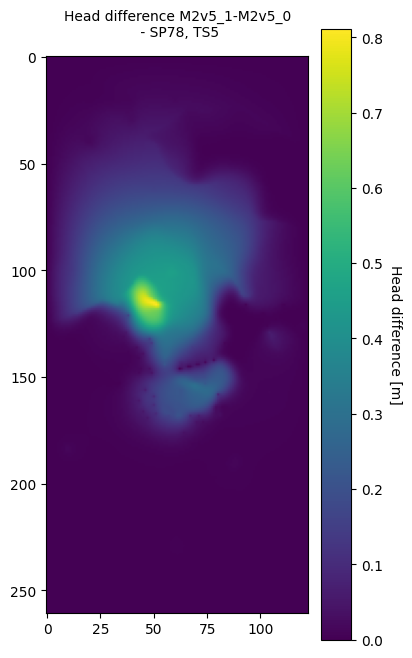

In [ ]:
# Plot the differences
fig, ax = plt.subplots(1,1, figsize = dv.cm2inch(5*2,30*2))
# Create colorbar

im = ax.imshow(diff)

cbar = fig.colorbar(im, fraction=0.1, pad=0.04)
cbar.ax.set_ylabel('Head difference [m]', rotation=-90, va = "bottom")

ax.set_title(f'Head difference {model_name_1}-{model_name_2}\n - SP{sp_ref}, TS{ts_ref}', y = 1.02, fontsize = 10)
fig.savefig(os.path.join(model_cwd_1, 'plot', f'map-diff-{model_name_1}-{model_name_2}-sp{sp_ref}-ts{ts_ref}.png'), bbox_inches = 'tight', dpi = 300)

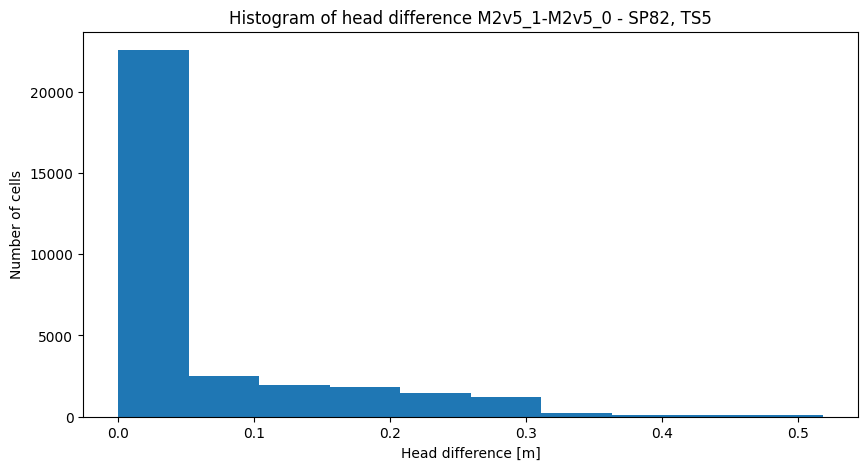

In [305]:
# Plot the 
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.hist(diff.flatten(), bins=10)
ax.set_xlabel('Head difference [m]')
ax.set_ylabel('Number of cells')
ax.set_title(f'Histogram of head difference {model_name_1}-{model_name_2} - SP{sp_ref}, TS{ts_ref}')
fig.savefig(os.path.join(model_cwd_1, 'plot', f'hist-diff-{model_name_1}-{model_name_2}-sp{sp_ref}-ts{ts_ref}.png'), bbox_inches = 'tight', dpi = 300)

In [301]:
# Print and save report
diff = hds12d - hds22d
vol_increase = (diff*0.2*100*100).sum()
print(model_name_1, '-', model_name_2)
print(f'SP{sp_ref}, TS{ts_ref}')
print(f'Volume increase in layer {layer}:', round(vol_increase), 'm3')

with open(os.path.join(model_cwd_1, 'plot', f'vol_diff_{model_name_1}-{model_name_2}_sp{sp_ref}_ts{ts_ref}.txt'), 'w') as f:
    f.write(f'{model_name_1} - {model_name_2}\n')
    f.write(f'SP{sp_ref}, TS{ts_ref}\n')
    f.write(f'Volume increase in layer {layer}: {round(vol_increase)} m3')

M2v5_1 - M2v5_0
SP78, TS5
Volume increase in layer 1: 4268273 m3


### Two periods comparison

In [ ]:
# Setup parameters
# Reference SP
sp_ref_1 = 78 # 78: end of irr, 82: end of simulation, before irrigation season
sp_ref_2 = 82 # 78: end of irr, 82: end of simulation, before irrigation season
ts_ref = 5  # reference time step
# Reference layer
layer = 1
# Model 1
model_cwd_1 = model_cwd
model_name_1 = model_name
# Model 2
model_cwd_2 = 'D:/MAURICE/MAURICE Model/MAU_v2/MAU_v2_transient/MAU_v2_5_0'
model_name_2 = 'M2v5_0'

# If ModflowUSG
nodes_ref = pd.read_csv('D:/MAURICE/MAURICE Model/MAU_v2/props_for_postprocessing/nodes_row_column.csv')

In [ ]:
# For MODFLOW-USG
hds1 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_1, f'{model_name_1}.hds'))
hds2 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_2, f'{model_name_2}.hds'))

# Obtain difference
hds12d = get_hds2d(hds1, nodes_ref, layer, ts_ref, sp_ref_1) # 18s, could be improved
hds22d = get_hds2d(hds2, nodes_ref, layer, ts_ref, sp_ref_1) # 18s, could be improved
diff_1 = hds12d-hds22d

hds12d = get_hds2d(hds1, nodes_ref, layer, ts_ref, sp_ref_2) # 18s, could be improved
hds22d = get_hds2d(hds2, nodes_ref, layer, ts_ref, sp_ref_2) # 18s, could be improved
diff_2 = hds12d-hds22d

hds1.close()
hds2.close()

In [ ]:
# Plot the differences
fig, axes = plt.subplots(1, 2, figsize = dv.cm2inch(10*2,30*2))
# Create colorbar

im1 = axes[0].imshow(diff_1, vmin = diff_1.min(), vmax = diff_1.max())
im2 = axes[1].imshow(diff_2, vmin = diff_1.min(), vmax = diff_1.max())

axes[0].set_title(f'Head difference {model_name_1}-{model_name_2}\n - SP82, TS5', y = 1.02, fontsize = 10)
axes[1].set_title(f'Head difference {model_name_1}-{model_name_2}\n - SP78, TS5', y = 1.02, fontsize = 10)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.375, 0.04, 0.24], transform = axes[1].transAxes)
fig.colorbar(im2, cax=cbar_ax)

full_geom_1 = draw_fields(diff_1, fields, plot = False)
full_geom_2 = draw_fields(diff_2, fields, plot = False)
for geom in full_geom_1.geoms:
    axes[0].plot(*geom.exterior.xy, linewidth=1, color='w')
for geom in full_geom_2.geoms:
    axes[1].plot(*geom.exterior.xy, linewidth=1, color='w')

fig.savefig(os.path.join(model_cwd_1, 'plot', f'map-diff-{sp_ref_1}-{sp_ref_2}.png'), bbox_inches = 'tight', dpi = 300)

## Mass balance

In [43]:
# From .cbb
cbb = fp.utils.CellBudgetFile(os.path.join(model_cwd, f'{model_name}.cbb'))

# If ModflowUSG
nodes_ref = pd.read_csv('D:/MAURICE/MAURICE Model/MAU_v2/props_for_postprocessing/nodes_row_column.csv')

In [65]:
def get_cbb2d(cbb1d, nodes_ref, layer, ts, sp, text):
    """
    ## CAREFUL ##
    This has been tested on a simple grid, without quad-trees or other
    grid changes, so the numbering of nodes is pretty straightforward
    (the numbering was assigned by GWV9)

    Obtain a 2d hds numpy array with the same dimensions as the MODFLOW grid,
    starting from a flopy.utils.binaryfile.HeadUFile.
    Need to provide a correspondence between nodes, row and column (nodes_ref)
    Works on a single layer, timestep and stress period

    hds1d: flopy.utils.binaryfile.HeadUFile
    nodes_ref: pandas.DataFrame
        columns needed:
            - node
            - row
            - column
    layer: int
        Layer to extract
    ts: int
        Time step to extract
    sp: int
        Stress period to extract
    """
    cbb1d = cbb1d.get_data(kstpkper = (ts-1, sp-1), text = text)[0]
    cbb1d = cbb1d[0,0,nodes_ref.row.max()*nodes_ref.column.max()*(layer-1):nodes_ref.row.max()*nodes_ref.column.max()*layer]
    cbb2d = np.zeros(shape = (nodes_ref.row.max(), nodes_ref.column.max()))
    for r in range(cbb2d.shape[0]):
        for c in range(cbb2d.shape[1]):
            cbb2d[r,c] = cbb1d[nodes_ref.loc[(nodes_ref.row == r+1) & (nodes_ref.column == c+1)].node.values[0]-1]
    return cbb2d

In [66]:
cbb2d = get_cbb2d(cbb, nodes_ref, 1, 5, 78, text='DRAINS')

In [ ]:
# Litta
# 18894
# 154
# 75

In [69]:
cbb2d[153,74]

np.float64(-0.018780795857310295)

### From GWV Boundary Reach Report


In [ ]:
# Load the Boundary Reach Report (obtained through)
brr = pd.read_csv(os.path.join(model_cwd, 'post', 'brr.csv'), skiprows=2)

# Obtain field "date"
dates = [date_start + datetime.timedelta(0, t) for t in brr.Time]
brr['Date'] = dates

In [ ]:
# Extract reach
tool = brr.loc[(brr['Reach or Zone'] > 500) & (brr['Reach or Zone'] < 670), :]

In [103]:
font_dict = {
    'Borghese': 533,
    'Branzino': 631,
    'Busca': 608,
    'Cicogna': 565,
    'Ghiglio': 566,
    'Litta': 618,
    'Nuovo': 627,
    'Pobbia': 624,
    'Torchiana': 641,
    'Tedesco': 603
}

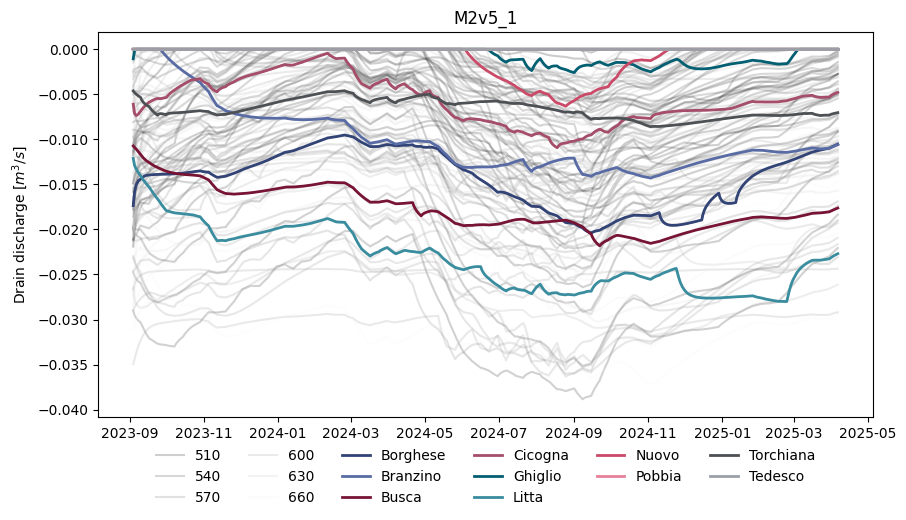

In [150]:
cmap = load_cmap("pal_unikn_dark")

fig, ax = plt.subplots(1,1, figsize = (10,5))

sns.lineplot(tool, x = 'Date', y = 'Drain', hue = 'Reach or Zone', palette = 'gray', alpha = 0.2)

ax.set_xlabel('')
ax.set_ylabel('Drain discharge [$m^3/s$]')

for font, c in zip(font_dict.keys(), cmap.hex):
    ax.plot(tool.loc[tool['Reach or Zone'] == font_dict[font], ['Date', 'Drain']].set_index('Date'), color = c, label = font, linewidth = 2)

ax.set_title(model_name)
ax.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol = 6, fancybox = False, frameon = False)

fig.savefig(os.path.join(model_cwd, 'plot', f'cbb-{model_name}-drains-lowland-springs.png'), bbox_inches = 'tight', dpi = 300)

## Video of changing head differences

**CAREFUL**: the creation of the 3d array takes 36s for each iteration\
E.g. for 410 iterations it takes 4 hours

The function get_hds2d needs to be improved to speed up the process

In [4]:
# Setup parameters
nsp = 82    # number of stress periods
nts = 5     # number of time steps
# Reference layer
layer = 1
# Number of rows and columns
nrows = 261
ncols = 123
# Model 1
model_cwd_1 = 'D:/MAURICE/MAURICE Model/MAU_v2/MAU_v2_transient/MAU_v2_5_1'
model_name_1 = 'M2v5_1'
# Model 2
model_cwd_2 = 'D:/MAURICE/MAURICE Model/MAU_v2/MAU_v2_transient/MAU_v2_5_0'
model_name_2 = 'M2v5_0'

# If ModflowUSG
nodes_ref = pd.read_csv('D:/MAURICE/MAURICE Model/MAU_v2/props_for_postprocessing/nodes_row_column.csv')

In [ ]:
# Obtain a 3d ndarray with differences for each time step
hds1 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_1, f'{model_name_1}.hds'))
hds2 = fp.utils.binaryfile.HeadUFile(os.path.join(model_cwd_2, f'{model_name_2}.hds'))

diff3d = np.ndarray(shape = (nsp*nts, nrows, ncols))
i = 0
for sp in range(1, nsp+1):
    for ts in range(1, nts+1):
        hds12d = get_hds2d(hds1, nodes_ref, layer, ts, sp) # 18s, could be improved
        hds22d = get_hds2d(hds2, nodes_ref, layer, ts, sp) # 18s, could be improved
        diff3d[i,:,:] = hds12d-hds22d
        i+=1

hds1.close()
hds2.close()

# Save as a pickle
with open(os.path.join(model_cwd, 'plot', f'diffs-{model_name_1}-{model_name_2}.pkl'), 'wb') as f:
    pickle.dump(diff3d, f)

In [ ]:
# Create an animation 
# https://matplotlib.org/stable/gallery/animation/dynamic_image.html#sphx-glr-gallery-animation-dynamic-image-py

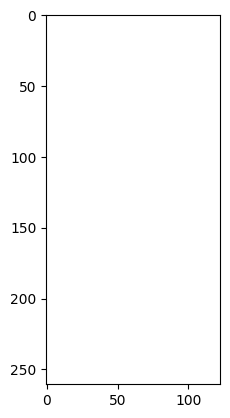

In [ ]:
fig, ax = plt.subplots()
ims = []

for i in range(diff3d.shape[0]):
    if i != 0:
        im = ax.imshow(diff3d[i,:,:], animated = True, vmin=diff3d.min(axis=0), vmax=diff3d.max(axis=0))
    else:
        im = ax.imshow(vmin=diff3d.min(axis=0), vmax=diff3d.max(axis=0))
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims)

#Migliorare il salvataggio, però funziona
#es diminuire il framerate, salvarlo come video

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1)
ani.save('test.gif', writer=writer)

from IPython.display import HTML
HTML(ani.to_jshtml())
# plt.show()

In [26]:
#check what is extracted
diff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(261, 123))